<a href="https://colab.research.google.com/github/ChaiRebahi/ChaiRebahi/blob/main/Audio_Processing_Using_Python/General_Audio_Processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**GENERAL**

[Librosa document](https://https://librosa.org/)

[Plot display specshow](https://librosa.org/doc/main/auto_examples/plot_display.html)

[More about soundfile](https://pypi.org/project/soundfile/)




In [ ]:
!pip install pesq

In [ ]:
#Requiered lib
import os
import librosa
import librosa.display
import IPython.display as ipd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from glob import glob
import soundfile as sf
from scipy.io import wavfile
from pesq import pesq
import pywt

#**READING AND LOADING AUDIO DATA**

we can use glob module to play all the audio files but in the rest of the notebook we will just use one audio file


```
audio_files = glob('/content/drive/MyDrive/audio2/0/*.wav')
print("Fichiers .wav trouvés :", audio_files)
ipd.Audio(audio_files[1])
```



In [ ]:
#path
audio_file ='/content/SA1.WAV.wav'

In [ ]:
#Play the audio wav
ipd.Audio(audio_file)

In [ ]:
y,sr = librosa.load(audio_file, sr=16000) # sr : sample rate | y: raw data of audio file stocked in a numpy array
print(f'y : {y[:10]}')
print(f'The sampled audio is returned as a numpy array (time series) and has : {y.shape} number of samples')
print(f'sr : {sr}')

y : [9.1552734e-05 1.5258789e-04 6.1035156e-05 6.1035156e-05 3.0517578e-05
 6.1035156e-05 9.1552734e-05 3.0517578e-05 6.1035156e-05 6.1035156e-05]
The sampled audio is returned as a numpy array (time series) and has : (63488,) number of samples
sr : 16000


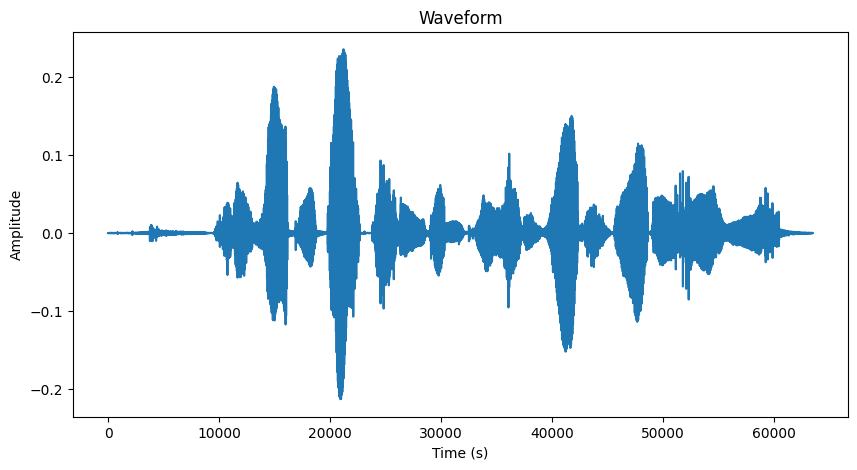

In [ ]:
plt.figure(figsize=(10,5))
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Waveform")
plt.plot(y)
plt.show()

#**TRIM AND ZOOM**

In [ ]:
help(librosa.effects.trim)

In [ ]:
# if we have some silence area in our audio file we use :
y_trimmed,_ = librosa.effects.trim(y, top_db = 10) # we consider that every value under top_db is silent and we delet it

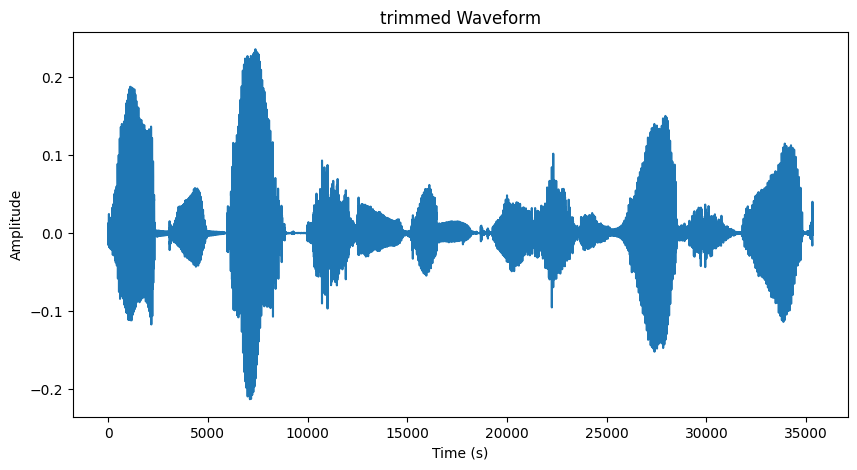

In [ ]:
plt.figure(figsize=(10,5))
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("trimmed Waveform")
plt.plot(y_trimmed)
plt.show()

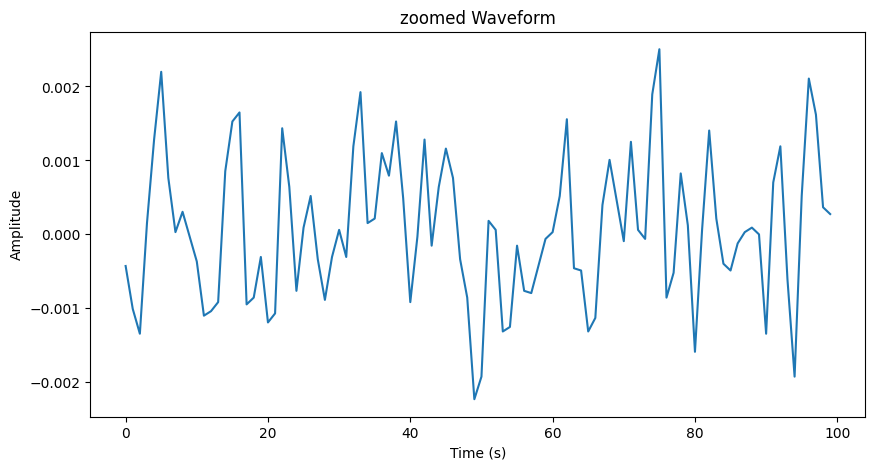

In [ ]:
#zoom in
plt.figure(figsize=(10,5))
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("zoomed Waveform")
plt.plot(y[5000:5100])
plt.show()

#**AUDIO REPRESENTATIONS (FEATURES EXTRACTION)**

#**STFT**

In [ ]:
# Size of the Fast Fourier Transform (FFT), which will also be used as the window length
n_fft=1024

# Step or stride between windows. If the step is smaller than the window length, the windows will overlap
hop_length=512

# Specify the window type for FFT/STFT
window_type ='hann'

# Sample rate
sr = 16000

In [ ]:
# calculate duration hop length and window in seconds
hop_length_duration = float(hop_length)/sr
n_fft_duration = float(n_fft)/sr
print(f' STFT hop length duration is : {hop_length_duration}s ')
print(f' STFT window duration is: {n_fft_duration}s .')

“STFT hop length duration is:0.032s ”
“STFT window duration is: 0.064s ”.


In [ ]:
# convert audio to stft
stft = librosa.stft(y,
                    n_fft= n_fft,
                    hop_length= hop_length,
                    win_length= n_fft,
                    window= window_type)

In [ ]:
print("The shape of stft_librosa is: ", stft[0].shape)
#print(stft[:2])

The shape of stft_librosa is:  (125,)


In [ ]:
# from stft to audio again
stft_inv = librosa.istft(stft,
                         n_fft=n_fft,
                         hop_length=hop_length,
                         window= window_type)
# convert to wav
sf.write('stft_inv.wav', stft_inv , samplerate=sr)

In [ ]:
# calcule de PESQ
rate, ref = wavfile.read("/content/SA1.WAV.wav")
rate, deg = wavfile.read("/content/stft_inv.wav")

print('in wide band mode : ',pesq(rate, ref, deg, 'wb'))
print('in narrow band mode : ',pesq(rate, ref, deg, 'nb'))

in wide band mode :  4.643573760986328
in narrow band mode :  4.548521995544434


#**SPECTROGRAM**

In [ ]:
help(librosa.stft)

In [ ]:
d_db=librosa.amplitude_to_db(np.abs(stft)**2,ref=np.max) # d_db : numpy array for the ordinary (linear) spectrogram without **2
d_db.shape

(513, 125)

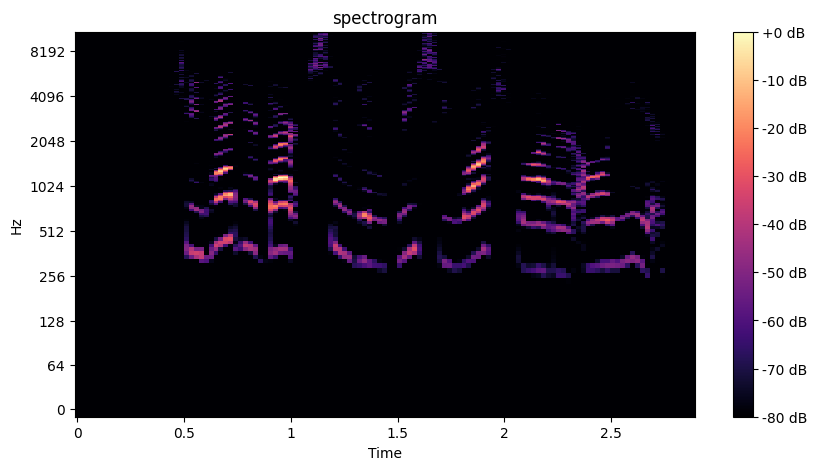

In [ ]:
fig, ax= plt.subplots(figsize=(10,5))
img = librosa.display.specshow(d_db,
                               x_axis = 'time',
                               y_axis = 'log',
                               ax = ax)
ax.set_title('spectrogram')
fig.colorbar(img, ax=ax, format="%+2.0f dB")


#**MEL SPECTROGRAM**

In [ ]:
help(librosa.feature.melspectrogram)

In [ ]:
# from audio to mel spectrogram
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
S_dB = librosa.power_to_db(S, ref=np.max)
S_dB.shape

(128, 125)

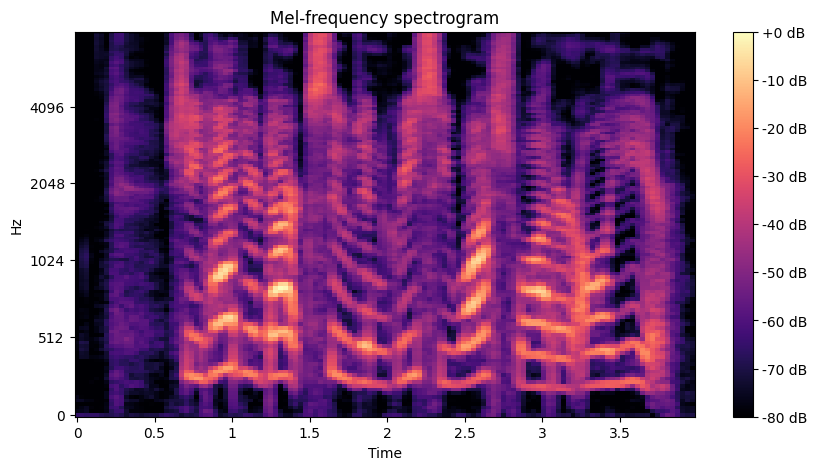

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
img = librosa.display.specshow(S_dB,
                               sr=sr,
                               x_axis='time',
                               y_axis='mel',
                               ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')
fig.savefig('./'+str(1)+'.png', bbox_inches='tight', pad_inches=0, dpi=128) # to save the plot as png

In [ ]:
# from mel to audio again
inv_mel = librosa.feature.inverse.mel_to_audio(S,
                                           sr=sr,
                                           n_fft=1024,
                                           hop_length=512,
                                           win_length=None,
                                           window='hann',
                                           center=True,
                                           pad_mode='reflect',
                                           power=2.0,
                                           n_iter=32)
                                           #n_mels=128)

In [ ]:
#save it as a wav file
sf.write("inv_mel.wav", inv_mel, sr)

In [ ]:
# If we want to save as .npy
with open('logMel.npy', 'wb') as f:
    np.save(f,S_dB)

# Load the saved data as a confirmation
with open('logMel.npy', 'rb') as f:
    a = np.load(f)
    print(a.shape)
    print(a)

# save as a.txt file
np.savetxt('logMel.out', S_dB, delimiter=',') # takes more space compared to saving as .npy

#**MFCC**

In [ ]:
help(librosa.feature.mfcc)

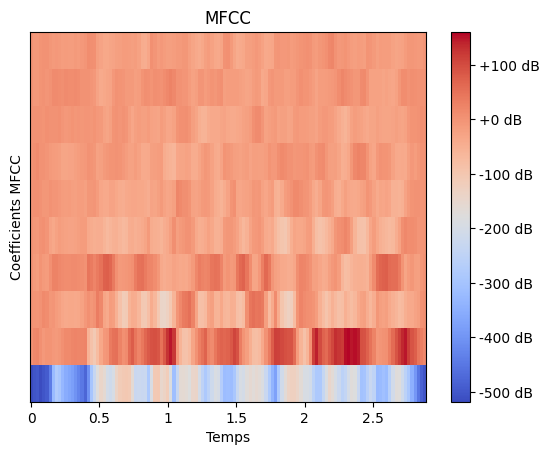

In [ ]:
# convert audio to mfcc
MFCCs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=10)
librosa.display.specshow(MFCCs, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('MFCC')
plt.xlabel('Temps')
plt.ylabel('Coefficients MFCC')
plt.show()

In [ ]:
# inverse mfcc to audio
mfcc_inver = librosa.feature.inverse.mfcc_to_audio(MFCCs,
                                                   sr=sr,
                                                   n_fft=n_fft,
                                                   hop_length=hop_length)


In [ ]:
#save it as a wav file

sf.write("inv_mfcc.wav", mfcc_inver, sr)

#**DWT**

In [ ]:
samplerate, data = wavfile.read('/content/SA1.WAV.wav');  # another way to reading the audio file
t = np.arange(len(data)) / float(samplerate);  # représente le temps en secondes associé à chaque échantillon audio.

print("data -> ", data)
print("data length -> ", len(data))
print("np.arange(len(data)) -> ", np.arange(len(data)))
print("float(samplerate) -> ", float(samplerate))
print("time -> ", t)

data = data/max(data);  # to normalize Audio Data [-1,1]
print("normalized data -> ", data)

data ->  [ 3  5  2 ...  8 10  7]
data length ->  63488
np.arange(len(data)) ->  [    0     1     2 ... 63485 63486 63487]
float(samplerate) ->  16000.0
time ->  [0.0000000e+00 6.2500000e-05 1.2500000e-04 ... 3.9678125e+00 3.9678750e+00
 3.9679375e+00]
normalized data ->  [0.00038911 0.00064851 0.0002594  ... 0.00103761 0.00129702 0.00090791]


In [ ]:
ca,cd =pywt.dwt(data, "bior6.8", "per")
y=pywt.idwt(ca, cd, "bior6.8", "per")
wavfile.write('sampleR.wav', samplerate, y);  # writing y as Audio
wavfile.write('sampleA.wav', samplerate, ca);  # writing ca as Audio
wavfile.write('sampleD.wav', samplerate, cd);  # writing cd as Audio

NameError: ignored